# Embedding for images

In [1]:
import numpy as np # Used for storing embeddings .
import torch # For device selection , model execution and tensor operation .
from PIL import Image # Used for image creation and other image operation .
import open_clip # Image embedding model .
from typing import List, Dict # Used for type return .

In [2]:
# Used for loading embedding model and embedding images with their caption .
class ImageEmbeddingModel:
    def __init__(self,model_name:str="ViT-B-32",pretrained:str="laion2b_s34b_b79k"):

        self.device="cuda" if torch.cuda.is_available() else "cpu" # Used to check if the machine has GPU if not assign CPU as device for working .
        self.model,self.preprocess,self.tokenizer=open_clip.create_model_and_transforms(
            model_name=model_name,
            pretrained=pretrained
        ) # Getting essential function from model .

        self.model=self.model.to(self.device) # Device selection for model operations .
        self.model.eval() # Loading model

        # Displaying device on which model will run .
        if self.device=="cuda":
            print(f"OpenClip running on {torch.cuda.get_device_name(0)} .")
        else:
            print("OpenClip running on CPU .")

    # Using no grad since by default torch assumes it is used for training model and do various backpropagation tasks which are not required here and only forward pass is required .
    @torch.no_grad()
    def embed_image(self,image_objects:List[Dict])->List[np.ndarray]:
        if not image_objects:
            raise ValueError("No images in the image object .")
        image_objects_embeddings=[] # Used for storing image embeddings .

        for image_object in image_objects: # Iterating through image objects .
            image_path=image_object["path"] # Fetching location of image.
            image=Image.open(image_path).convert("RGB") # Converting RGB if image is not already in RGB .
            image_tensor=self.preprocess(image).unsqueeze(0).to(self.device) # Converting into tensor since openclip cant embedd other inputs .

            emb_imag=self.model.encode_image(image_tensor) # Embedding images
            emb_imag=emb_imag/emb_imag.norm(dim=-1,keepdim=True) # Normalizing images

            emb_imag=emb_imag.cpu().numpy()[0] # Converting tensor output to numpy array . Using .cpu since numpy cannot access gpu memory ,it should be in ram memory then numpy can access memory and can convert it into numpy array .

            if image_object["caption_text"]: # If caption is available for the image then embedd it .
                caption=image_object["caption_text"]
                tokens=open_clip.tokenize([caption]).to(self.device) # Used to convert into tensor .

                emb_text=self.model.encode_text(tokens) # Embedding text or tensor value .
                emb_text=emb_text/emb_text.norm(dim=-1,keepdim=True) # Normalizing values

                emb_text=emb_text.cpu().numpy()[0] # Converting tensor to numpy array .

                fused=emb_imag+emb_text # Fusing image and caption together .It does not change the meaning .

                norm= np.linalg.norm(fused)
                if norm>0:
                    fused=fused / norm # Normalizing fused values .

                image_objects_embeddings.append(fused) # Appending embeddings .

            else:
                image_objects_embeddings.append(emb_imag) # If no captions only images are embedded and appended .

        return image_objects_embeddings # Returning all the embeddings .

In [3]:
image_model = ImageEmbeddingModel() # Loading model .

OpenClip running on NVIDIA GeForce RTX 3050 6GB Laptop GPU .


In [4]:
from PIL import ImageDraw # Used to create a image .

In [5]:
img = Image.new("RGB", (400, 300), "white") # Creating a blank image .
draw = ImageDraw.Draw(img)

draw.rectangle([50, 50, 350, 250], outline="black", width=3) # Creating a triangle .
draw.text((120, 140), "Bias Variance", fill="black") # A text inside a box

img.save("../data/test_images/test_image.png") # Saving image .
print("Saved test_image.png")

Saved test_image.png


In [6]:
import matplotlib.pyplot as plt # For displaying image .

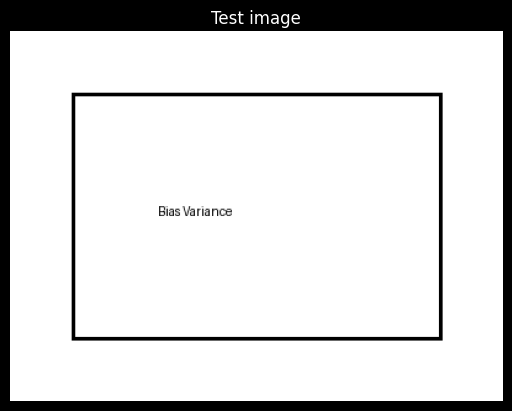

In [7]:
#Displaying test image .
test_image=Image.open("../data/test_images/test_image.png")
plt.imshow(test_image)
plt.axis("off")
plt.title("Test image")
plt.show()

In [8]:
# Creating a test image object .
image_objects = [
    {
        "image_id": "test_img_1",
        "path": "test_image.png",
        "caption_text": "Bias variance tradeoff diagram",
        "source": "unit_test",
        "page_num": 1,
        "bbox": [0, 0, 400, 300]
    }
]

In [9]:
image_embeddings = image_model.embed_image(image_objects) # Creating embeddings .

In [10]:
# Details about image embedding .
print("Number of embeddings:", len(image_embeddings))
print("Embedding shape:", image_embeddings[0].shape)
print("Embedding L2 norm:", np.linalg.norm(image_embeddings[0]))

Number of embeddings: 1
Embedding shape: (512,)
Embedding L2 norm: 1.0


In [11]:
image_embeddings[0][:100] # Displaying only first 100 vectors of image .

array([-3.1581692e-02,  6.8287939e-02,  1.1431051e-02, -4.9217690e-02,
       -1.5946979e-02,  2.4762062e-02,  2.6639581e-02, -3.2111760e-02,
        1.3238541e-02,  3.1832445e-02, -2.2001790e-03, -2.5972907e-02,
       -2.4729891e-02,  1.6912680e-02,  2.7349034e-02, -1.9847481e-03,
       -2.4579107e-03, -2.8936736e-02,  2.0858616e-02,  3.9522253e-02,
       -6.1152205e-03, -1.8011864e-02, -4.6620391e-02, -1.7663253e-02,
        2.8710078e-02,  3.6942374e-02,  3.8816661e-02,  2.4634130e-02,
        5.8818422e-03, -4.2670436e-02,  5.7039458e-02,  2.3086859e-02,
       -8.6038947e-02,  3.3985700e-02,  7.6020830e-03,  5.2327286e-02,
        4.9606904e-02, -3.8741890e-02,  3.4758575e-02,  1.3869371e-02,
       -1.7099325e-02,  5.6585610e-02,  1.3118730e-02,  1.5918035e-02,
       -6.2628286e-03, -1.4060762e-02, -2.7199015e-03, -9.7329300e-03,
        4.7614291e-02,  1.8487448e-02,  1.4838857e-02, -2.8593015e-02,
       -2.4045022e-02, -1.0945432e-02,  2.7024848e-02, -1.2386700e-02,
      

# Embedding for text

In [12]:
from sentence_transformers import SentenceTransformer # Used for loading model .
import numpy as np # Used to store embedding .
import torch # Used for device selection and model execution .
from typing import List # Used for return type .
from langchain_core.documents import Document # Used for storing documents .

In [13]:
# Used for loading model and embedding text .
class TextEmbeddingModel:

    def __init__(self,model_name:str= "BAAI/bge-base-en-v1.5"):
        self.device="cuda" if torch.cuda.is_available() else "cpu" # Device check .
        self.model=SentenceTransformer(model_name_or_path=model_name,device=self.device) # Loading model .

        if self.device=="cuda":
            print(f"BGE running on {torch.cuda.get_device_name(0)} .")
        else:
            print("BGE running on CPU .")

    @torch.no_grad()
    def embed_documents(self,documents:List[Document])->List[np.ndarray]:
        if not documents:
            raise ValueError("No documents to embed .")

        texts=[doc.page_content for doc in documents]

        # Embedding texts .
        # sentences -> input /texts
        # batch_size -> Number of inputs embedding a single time .
        # convert_to_numpy -> Convert output to numpy array .
        # normalize_embeddings -> Normalizing all the out vectors .
        text_embeddings=self.model.encode(
            sentences=texts,
            batch_size=32,
            convert_to_numpy=True,
            normalize_embeddings=True
        )

        return text_embeddings # Return embeddings .


In [14]:
text_model = TextEmbeddingModel() # Loading model .

BGE running on NVIDIA GeForce RTX 3050 6GB Laptop GPU .


In [15]:
# Test data
documents = [
    Document(
        page_content="The bias variance tradeoff explains the balance between underfitting and overfitting in machine learning.",
        metadata={"chunk_id": "c1", "page_num": 1}
    ),
    Document(
        page_content="Overfitting occurs when a model learns noise in the training data instead of the underlying pattern.",
        metadata={"chunk_id": "c2", "page_num": 1}
    ),
    Document(
        page_content="Regularization techniques such as L2 penalty help reduce overfitting by constraining model complexity.",
        metadata={"chunk_id": "c3", "page_num": 2}
    )
]

In [16]:
text_embeddings = text_model.embed_documents(documents) # Passing data or embedding input .

In [17]:
# Details of embeddings
print("Number of embeddings:", len(text_embeddings))
print("Embedding shape:", text_embeddings[0].shape)
print("Embedding L2 norm:", np.linalg.norm(text_embeddings[0]))

Number of embeddings: 3
Embedding shape: (768,)
Embedding L2 norm: 1.0


In [18]:
text_embeddings[0][:100] # Embeddings of first document

array([-0.00750077, -0.01657214,  0.02134528,  0.03737882,  0.00916659,
        0.00445431,  0.0467957 ,  0.0081098 , -0.02130136, -0.04648071,
        0.06370625,  0.0443725 , -0.07843439, -0.01442318, -0.02948426,
        0.03460341,  0.030627  ,  0.00833811,  0.03319671,  0.00328724,
       -0.00491366, -0.00731131,  0.0147004 , -0.00487739,  0.00527096,
        0.00481392,  0.01197181, -0.01464292, -0.01389897,  0.06801087,
        0.07143721,  0.02321669, -0.04086312, -0.00409608, -0.01635015,
        0.01832462, -0.00466213, -0.03060478, -0.01251492,  0.03860732,
       -0.05658573,  0.02579218, -0.02520276,  0.03879949, -0.06607064,
       -0.00870941, -0.12635188,  0.01515684, -0.02914351, -0.08872724,
       -0.07440807,  0.03215913, -0.02752695,  0.00591359,  0.00066573,
        0.03919731,  0.0353061 , -0.02116826, -0.03174032, -0.02149748,
       -0.01491818,  0.03312138,  0.01685498, -0.02782962,  0.00900965,
        0.02998906, -0.00292024,  0.03930453, -0.06367826, -0.04